In [ ]:

import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import os

# Force CPU mode
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all, 1 = info, 2 = warning, 3 = error

# Optional: avoid protobuf warnings in TF 2.x
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# 1. LOAD DATASET
train_df = pd.read_csv("/kaggle/input/dataset-gru/train.csv")
val_df   = pd.read_csv("/kaggle/input/dataset-gru/validation.csv")
test_df  = pd.read_csv("/kaggle/input/dataset-gru/test.csv")

X_train = train_df['cleaned_text'].astype(str).values
X_val   = val_df['cleaned_text'].astype(str).values
X_test  = test_df['cleaned_text'].astype(str).values

y_train = train_df.iloc[:, -1].values
y_val   = val_df.iloc[:, -1].values
y_test  = test_df.iloc[:, -1].values

In [ ]:
# 2. LABEL ENCODING

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# Create the LabelEncoder object
encoder = LabelEncoder()

# Fit on training labels and transform
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

# Number of classes
num_classes = len(encoder.classes_)

# Convert to one-hot vectors
y_train_cat = to_categorical(y_train_enc, num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes)

print("Label encoding completed successfully!")
print("Number of classes:", num_classes)


Label encoding completed successfully!
Number of classes: 3


In [ ]:
# 3. TEXT VECTORIZATION
MAX_TOKENS = 10000
SEQUENCE_LENGTH = 150
EMBED_DIM = 128

text_vec = TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH,
)

text_vec.adapt(X_train)

In [ ]:
# 4. BUILD MODEL (Functional API)

input_text = Input(shape=(1,), dtype=tf.string)

x = text_vec(input_text)
x = Embedding(MAX_TOKENS, EMBED_DIM)(x)

# CNN block
x = Conv1D(128, 5, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)

# BiLSTM
x = Bidirectional(LSTM(128, return_sequences=False))(x)

# Fully connected
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_text, outputs=output)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 150)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 150, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 150, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 75, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 37, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,715,843 (6.55 MB)

 Trainable params: 1,715,843 (6.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 5. TRAIN

history = model.fit(
    X_train,
    y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 44s 116ms/step - accuracy: 0.5393 - loss: 0.9260 - val_accuracy: 0.7458 - val_loss: 0.6303
Epoch 2/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.8215 - loss: 0.4543 - val_accuracy: 0.8670 - val_loss: 0.2970
Epoch 3/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 35s 112ms/step - accuracy: 0.9230 - loss: 0.2007 - val_accuracy: 0.9010 - val_loss: 0.2453
Epoch 4/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.9629 - loss: 0.1090 - val_accuracy: 0.9037 - val_loss: 0.2563
Epoch 5/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 36s 115ms/step - accuracy: 0.9781 - loss: 0.0764 - val_accuracy: 0.9051 - val_loss: 0.2729
Epoch 6/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 38s 119ms/step - accuracy: 0.9858 - loss: 0.0480 - val_accuracy: 0.9065 - val_loss: 0.3184
Epoch 7/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.9893 - loss: 0.0389 - val_accuracy: 0.8975 - val_loss: 0.3989
Epoch 8/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 53s 168ms/step - accuracy: 0.9879 - loss: 0

91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

    negative       0.81      0.77      0.79       245
     neutral       0.92      0.90      0.91      1589
    positive       0.90      0.92      0.91      1054

    accuracy                           0.90      2888
   macro avg       0.87      0.87      0.87      2888
weighted avg       0.90      0.90      0.90      2888



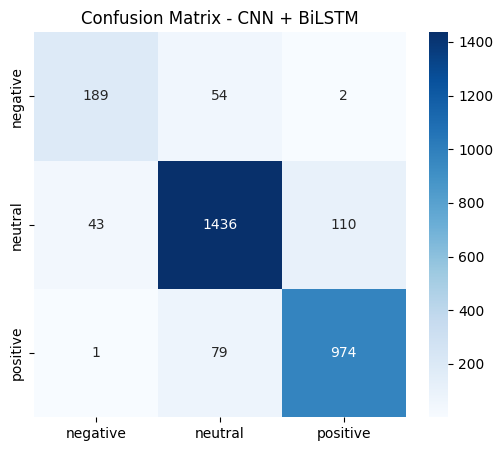

In [ ]:
# 6. EVALUATION

pred_probs = model.predict(X_test)
pred = np.argmax(pred_probs, axis=1)

print("\nCLASSIFICATION REPORT:\n")
print(classification_report(y_test_enc, pred, target_names=encoder.classes_))

cm = confusion_matrix(y_test_enc, pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title("Confusion Matrix - CNN + BiLSTM")
plt.show()

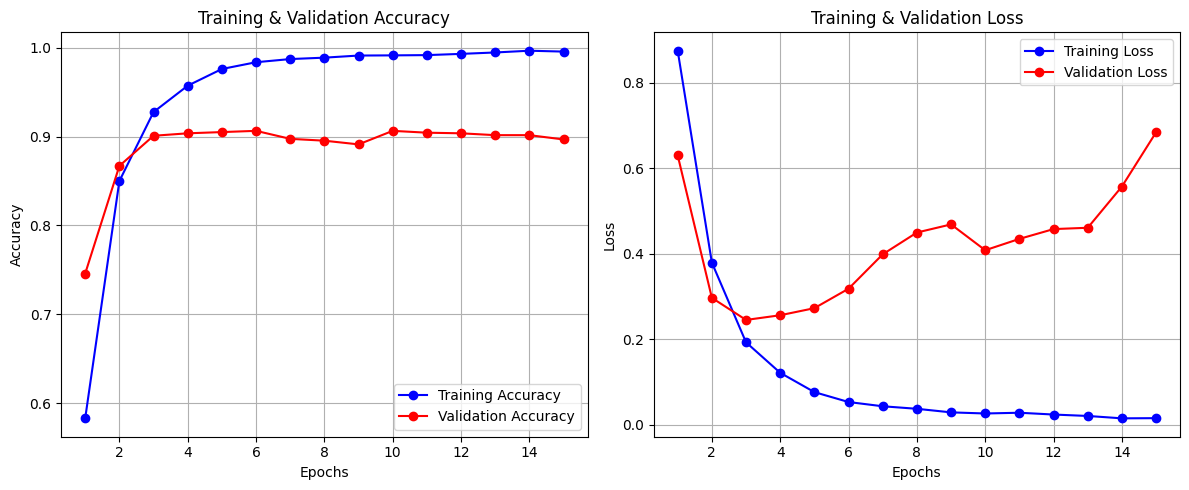

In [ ]:
# 7. PLOT TRAINING & VALIDATION CURVES

import matplotlib.pyplot as plt

# Extract history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()